# Software Defect Prediction
#### An Exploration of Model Interpretability in Software Defect Analysis

`Aidan Goodyer (goodyera@mcmaster.ca)` `Mason Azzopardi (azzoparm@mcmaster.ca)`


___

### Imports and Dataset Loading

In [8]:
%%capture
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

df = pd.read_csv('dataset/dataset_csv/MC1.csv')

### Design Matrix and Label Construction, Standardization

We use ***z-score normalization*** to standardize our dataset so that we have a reliable scale to compare each metric against one and other.

Our design matrix is normalized as follows: 

$$ \phi(x) = \frac{x-\mu}{\sigma}$$

where:

$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i \hspace{5mm} \sigma = \sqrt{ \frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2} $$

with $x$ representing our individual raw features and the design matrix being the resulting matrix of $\phi(x)$ features.

<Axes: >

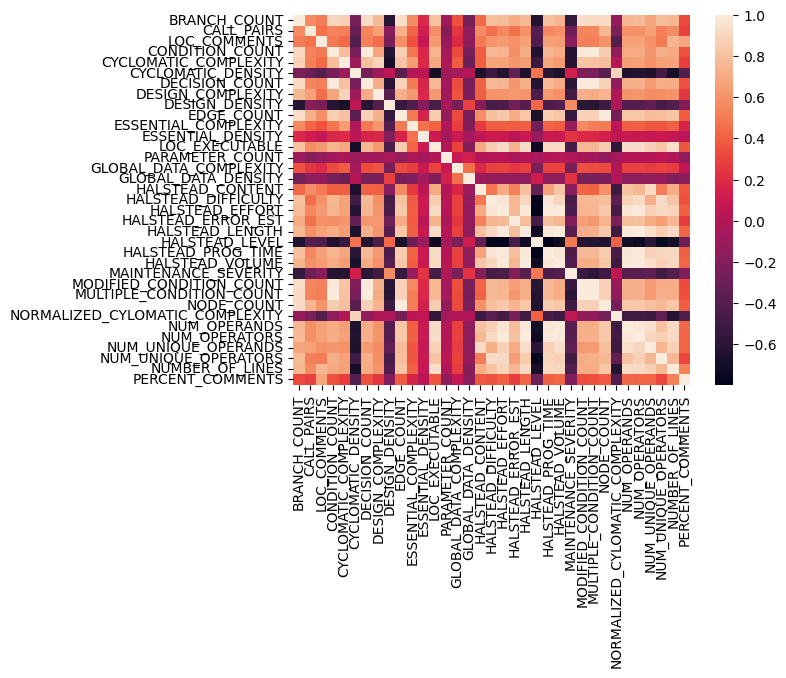

In [10]:
columns_dropped = [
    'LOC_BLANK', 'LOC_TOTAL', 'LOC_CODE_AND_COMMENT', # proxies for LOC
    # 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY', 'BRANCH_COUNT', 
]

df = raw_features = df.drop(columns = columns_dropped)

raw_features = df.iloc[:, :-1].values.astype(float)



raw_features = np.log1p(raw_features) # log transform

mu = np.mean(raw_features, axis=0)
sigma = np.std(raw_features, axis=0)

X = (raw_features-mu)/sigma
y = df.iloc[:,-1].apply(lambda x: 1 if str(x) == 'Y' else 0).values

correlation_matrix = pd.DataFrame(X).corr()

feature_names = df.columns[:-1]
sns.heatmap(correlation_matrix, xticklabels=feature_names, yticklabels=feature_names)


# Model

The Logistic Regression approach we employ is defined below. 

---

### Gradients



We base our model on the Gradient Descent for Logistic Regression Algorithm described in the Lecture Note.



 $$  p(i) = \sigma( \theta^{t^\intercal} x^{(i)} + \theta_0) = \frac{1}{1+e^{- (\theta^{t^\intercal} x^{(i)} + \theta_0) }} $$


$$\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} (p^{(i)} - 1_{\{y^{(i)}=+1\}}) \mathbf{x}^{(i)} + \lambda \cdot \text{sign}(\boldsymbol{\theta}^{(t)})$$



$$\nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} (p^{(i)} - 1_{\{y^{(i)}=+1\}})$$


Note since we are using **L1** Regularization, we have adjusted the gradient of the $\lambda$ term to be $\text{sign}(\boldsymbol{\theta}^{(t)})$ since $\frac{d}{dx} \left|x\right| = \text{sign}(x) $ 


---
### Update Rule 



Using these gradients, our update rule becomes: 

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$

$$\theta_0^{(t+1)} = \theta_0^{(t)} - \eta \nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$


---

The following python code implements the equations defined above:

In [11]:

n, d = X.shape

eta = 0.1
theta = np.zeros(d)
theta_zero = 0 
l1_reg = 0.02
epochs = 1000

accuracy_v = [] # store accuracy 

def sigmoid(x):
    return 1/(1+np.exp(-x))


for i in range(epochs):
    z = np.dot(X,theta) + theta_zero
    p = sigmoid(z)

    predictions = (p>=0.3).astype(int)
    accuracy = np.mean(predictions==y)
    accuracy_v.append(accuracy)


    error = p-y

    asymmetric_error = np.where(y==1, error*4, error)

    d_theta = (1/n)*np.dot(X.T, asymmetric_error) + l1_reg*np.sign(theta)
    d_theta_zero = (1/n)*np.sum(p-y)

    theta -= eta*d_theta
    theta_zero -= eta*d_theta_zero

In [12]:
true_positives = np.sum( (predictions==1) & (y==1))
true_negatives = np.sum( (predictions==0) & (y==0))
false_positives = np.sum( (predictions==1) & (y==0))
false_negatives = np.sum( (predictions==0) & (y==1))


print('true positives: ', true_positives)
print('false positives: ', false_positives)


print('true negatives: ', true_negatives)
print('false negatives: ', false_negatives)


avg = np.average(predictions)

print(avg)


true positives:  2
false positives:  4
true negatives:  1912
false negatives:  34
0.0030737704918032786


## Results Analysis

### Feature Importance for Defect Prediction 
Metric Name | Weight Magnitude | Impact 
 | :--- | :--- | :--- 
| PERCENT_COMMENTS | 0.8586 | ⬆ Probability
| NUMBER_OF_LINES | 0.2910 | ⬆ Probability
| LOC_COMMENTS | 0.2884 | ⬆ Probability
| NODE_COUNT | 0.2206 | ⬆ Probability
| GLOBAL_DATA_DENSITY | 0.2145 | ⬇ Probability
| EDGE_COUNT | 0.1318 | ⬆ Probability
| CALL_PAIRS | 0.1286 | ⬆ Probability
| HALSTEAD_CONTENT | 0.0502 | ⬆ Probability
| MULTIPLE_CONDITION_COUNT | 0.0024 | ⬆ Probability
| NORMALIZED_CYLOMATIC_COMPLEXITY | 0.0022 | ⬇ Probability
| ESSENTIAL_COMPLEXITY | 0.0020 | ⬆ Probability
| MAINTENANCE_SEVERITY | 0.0019 | ⬇ Probability
| MODIFIED_CONDITION_COUNT | 0.0017 | ⬆ Probability
| DESIGN_COMPLEXITY | 0.0017 | ⬇ Probability
| NUM_UNIQUE_OPERATORS | 0.0016 | ⬆ Probability
| BRANCH_COUNT | 0.0015 | ⬆ Probability
| CONDITION_COUNT | 0.0014 | ⬆ Probability
| HALSTEAD_VOLUME | 0.0013 | ⬆ Probability
| NUM_OPERATORS | 0.0012 | ⬆ Probability
| GLOBAL_DATA_COMPLEXITY | 0.0011 | ⬇ Probability
| HALSTEAD_LEVEL | 0.0009 | ✖ Little Impact
| DESIGN_DENSITY | 0.0008 | ✖ Little Impact
| CYCLOMATIC_DENSITY | 0.0008 | ✖ Little Impact
| ESSENTIAL_DENSITY | 0.0008 | ✖ Little Impact
| HALSTEAD_EFFORT | 0.0007 | ✖ Little Impact
| LOC_EXECUTABLE | 0.0007 | ✖ Little Impact
| PARAMETER_COUNT | 0.0007 | ✖ Little Impact
| HALSTEAD_LENGTH | 0.0006 | ✖ Little Impact
| DECISION_COUNT | 0.0006 | ✖ Little Impact
| HALSTEAD_PROG_TIME | 0.0005 | ✖ Little Impact
| HALSTEAD_ERROR_EST | 0.0004 | ✖ Little Impact
| HALSTEAD_DIFFICULTY | 0.0004 | ✖ Little Impact
| NUM_UNIQUE_OPERANDS | 0.0003 | ✖ Little Impact
| CYCLOMATIC_COMPLEXITY | 0.0002 | ✖ Little Impact
| NUM_OPERANDS | 0.0002 | ✖ Little Impact


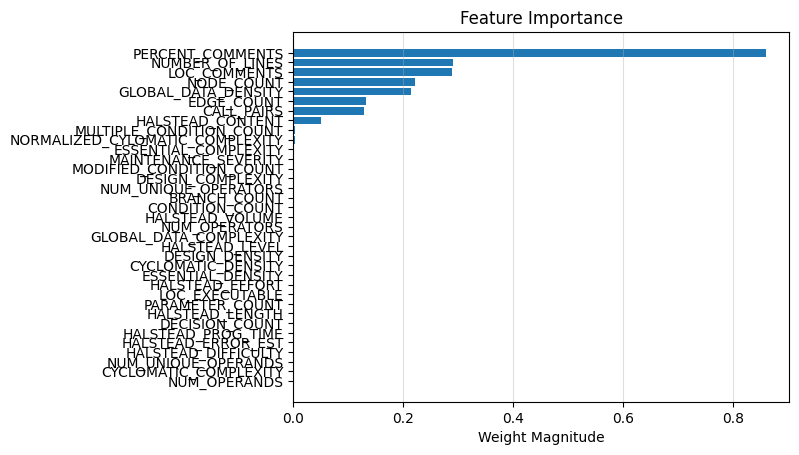

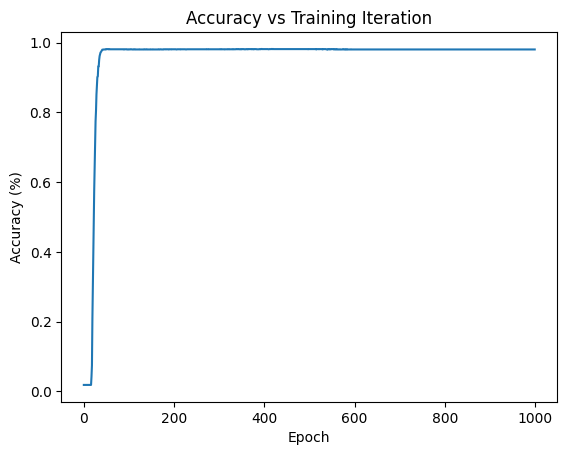

In [13]:
from IPython.display import display, Markdown

md_table = '### Feature Importance for Defect Prediction \n'
md_table += 'Metric Name | Weight Magnitude | Impact \n'
md_table += ' | :--- | :--- | :--- \n'

feature_names = df.columns[:-1]
importance = sorted(list(zip(feature_names,abs(theta),np.sign(theta))), key=lambda x: abs(x[1]), reverse=True)

for name, weight, sign in importance :

    impact = '✖ Little Impact' if (weight < 1e-3) else ('⬆ Probability' if sign>0 else '⬇ Probability')
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))


names = [name for name, _, _ in importance]
weight = [ weight for _, weight, _ in importance]


plt.title('Feature Importance')
plt.xlabel("Weight Magnitude")
plt.grid(axis='x', alpha=0.4)
plt.barh(names[::-1],weight[::-1])
plt.show()


plt.plot(accuracy_v, label='Training Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy vs Training Iteration')
plt.show()
